In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import plotly.express as px
from collections import Counter
import re
import numpy as np
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import category_encoders as ce

In [2]:
from sklearn import set_config
set_config(display='diagram')

In [ ]:
!python data-loader.py

# Challenge.

The goal of this challenge is to predict the average price of a wine bottle

# Data presentation.

The data is composed of the file `train.csv` which contains a list of wines with many features.

df_train = pd.read_csv('data/test.csv', sep=';', encoding='utf-8')
#df_train['note'] = df_train['note'].astype(int)
#df_train.to_csv('data/test2.csv', encoding='utf-8', sep=';', index=False)

df_train = df_train[df_train['prix_m'].notna()].reset_index(drop=True)
df_train

df_train.to_csv('data/test.csv', encoding='utf-8', sep=';', index=False)

In [3]:
df_train = pd.read_csv('data/train.csv', sep=';', encoding='utf-8')
df_train.head()

,vin,cuvee,millesime,guide,note,classement,region,appellation,type,prix,...,prod_id,adresse,CP,commune,pays,INSEE_COM,INSEE_DEP,INSEE_REG,lon,lat
0,CHÂTEAU MOUSSEYRON,NaN,2008.0,Guide 2010,1,NaN,Bordelais,Bordeaux blanc,Blanc tranquille,- de 5 €,...,13733.0,"31, rte de Gaillard",33490.0,Saint-Pierre-d'Aurillac,France,33463,33,75.0,-0.190335,44.572379
1,CHÂTEAU HAUT CORBIAN,NaN,2014.0,Guide 2018,1,NaN,Bordelais,Saint-estèphe,Rouge tranquille,11 à 15 €,...,48920.0,"16, rte du Vieux-Moulin Saint-Corbian",33180.0,Saint-Estèphe,France,33395,33,75.0,-0.772464,45.259352
2,DOMAINE BELLE,NaN,2010.0,Guide 2014,0,NaN,Vallée du Rhône,Hermitage,Rouge tranquille,30 à 50 €,...,49569.0,"510, rue de la Croix",26600.0,Larnage,France,26156,26,84.0,4.862945,45.097200
3,COUVREUR-PHILIPPART,Carte d'or,NaN,Guide 2016,1,1er cru,Champagne,Champagne,Blanc effervescent,11 à 15 €,...,67163.0,"12, rue de Reims",51500.0,Rilly-la-Montagne,France,51461,51,44.0,4.044316,49.165048
4,DOMAINE MADELOC,Serrail,2011.0,Guide 2015,2,NaN,Roussillon,Collioure,Rouge tranquille,11 à 15 €,...,48072.0,"1 bis, av. du Gal-de-Gaulle",66650.0,Banyuls-sur-Mer,France,66016,66,76.0,3.129439,42.481151


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113718 entries, 0 to 113717
Data columns (total 29 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           113718 non-null  object 
 1   cuvee         69071 non-null   object 
 2   millesime     105432 non-null  float64
 3   guide         113718 non-null  object 
 4   note          113718 non-null  int64  
 5   classement    12525 non-null   object 
 6   region        113718 non-null  object 
 7   appellation   113718 non-null  object 
 8   type          113718 non-null  object 
 9   prix          113718 non-null  object 
 10  prix_min      102741 non-null  float64
 11  prix_max      111701 non-null  float64
 12  prix_m        113718 non-null  float64
 13  consommation  35760 non-null   object 
 14  commentaire   109919 non-null  object 
 15  garde         35761 non-null   object 
 16  production    113718 non-null  int64  
 17  elevage       113718 non-null  object 
 18  prod

The training set contains 113 718 wines with those different features:
- 'vin': wine name,
- 'cuvee'
- 'millesime': wine vintage,
- 'guide': Hachette wine guide vintage of the evaluation,
- 'note': wine score according Hachette wine guide (from 0 to 3). Unknown scores are also noted as 0.
- 'classement': wine classification,
- 'region': production region,
- 'appellation',
- 'type',
- 'consommation': comment concerning wine consumption (delay before drink a bottle),
- 'commentaire': comment one wine's quality,
- 'garde': when filled, conservation duration,
- 'production': the number of bottles produced for this wine,
- 'elevage': the way the wine grew (barrel, tank...)
- 'producteur': producer's name
- 'prod_id': producer's identification number,
- 'adresse': producer's address,
- 'CP': postal zip code,
- 'commune': city,
- 'pays': country,
- 'INSEE_COM': administrative zip code,
- 'INSEE_DEP': department administrative zip code,
- 'INSEE_REG': region administrative zip code,
- 'lon': geographic coordinate - longitude
- 'la': geographic coordinate - latitude

And also:
- 'prix': price range,
- 'prix_min': minimum price,
- 'prix_max': maximum price,
- 'prix_m': average price.

We create a feature with the price quartile the wine belongs to.

In [5]:
df_train['prix_q'] = pd.qcut(df_train['prix_m'], 4, labels=False)

**The average price will constitute the target for the model.**

The train dataset has 113 718 wines from 1925 to 2020. Some wines don't possess any vintage, due to their specificity (champagne, ...) or to missing data.  

Before a deep dive in the features, let's hav an overview of the set

In [19]:
fig = px.scatter_mapbox(df_train.sort_values(by='region'),
                        lat='lat', 
                        lon='lon', 
                        hover_name="producteur",
                        hover_data=['region'],
                        color='region',
                        color_discrete_sequence=px.colors.qualitative.D3,
                        zoom=5)
fig.update_layout(title="Carte de France des producteurs de vins", mapbox_style="open-street-map")
fig.write_html('Carte de France - Producteurs.html', auto_open=True)

In [20]:
fig = px.scatter_mapbox(df_train.sort_values(by='appellation'),
                        lat='lat', 
                        lon='lon', 
                        hover_name="vin",
                        hover_data=['appellation', 'producteur', 'region'],
                        color='appellation',
                        color_discrete_sequence=px.colors.qualitative.D3,
                        zoom=5)
fig.update_layout(title="Carte de France des vins", mapbox_style="open-street-map")
fig.write_html('Carte de France - Appellations.html', auto_open=True)

To conclude this data presentation, we will explore each features trying to figure out whether the variable is linked to the price or not.

## First data insights.

Let's look at the price distribution in the set.

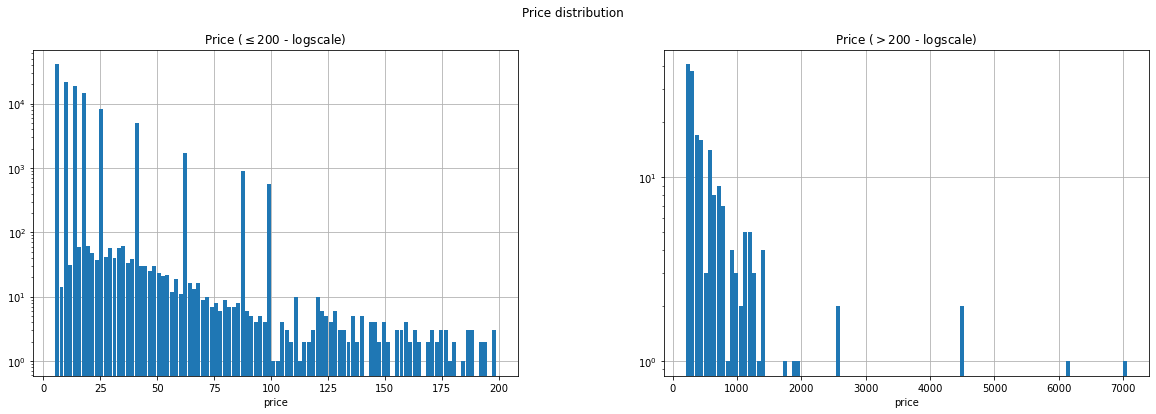

In [14]:
s = 200
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = [20,6])
df_train[df_train['prix_m']<= s].hist(column='prix_m', grid=True, zorder=2, bins=100, rwidth=0.9, ax=ax1, log=True)
df_train[df_train['prix_m']> s].hist(column='prix_m', grid=True, zorder=2, bins=100, rwidth=0.9, ax=ax2, log=True)
plt.suptitle('Price distribution')
ax1.set_title('Price ($\leq {}$ - logscale)'.format(s))
ax2.set_title('Price ($> {}$ - logscale)'.format(s))
ax1.set_xlabel('price')
ax2.set_xlabel('price')
plt.show()

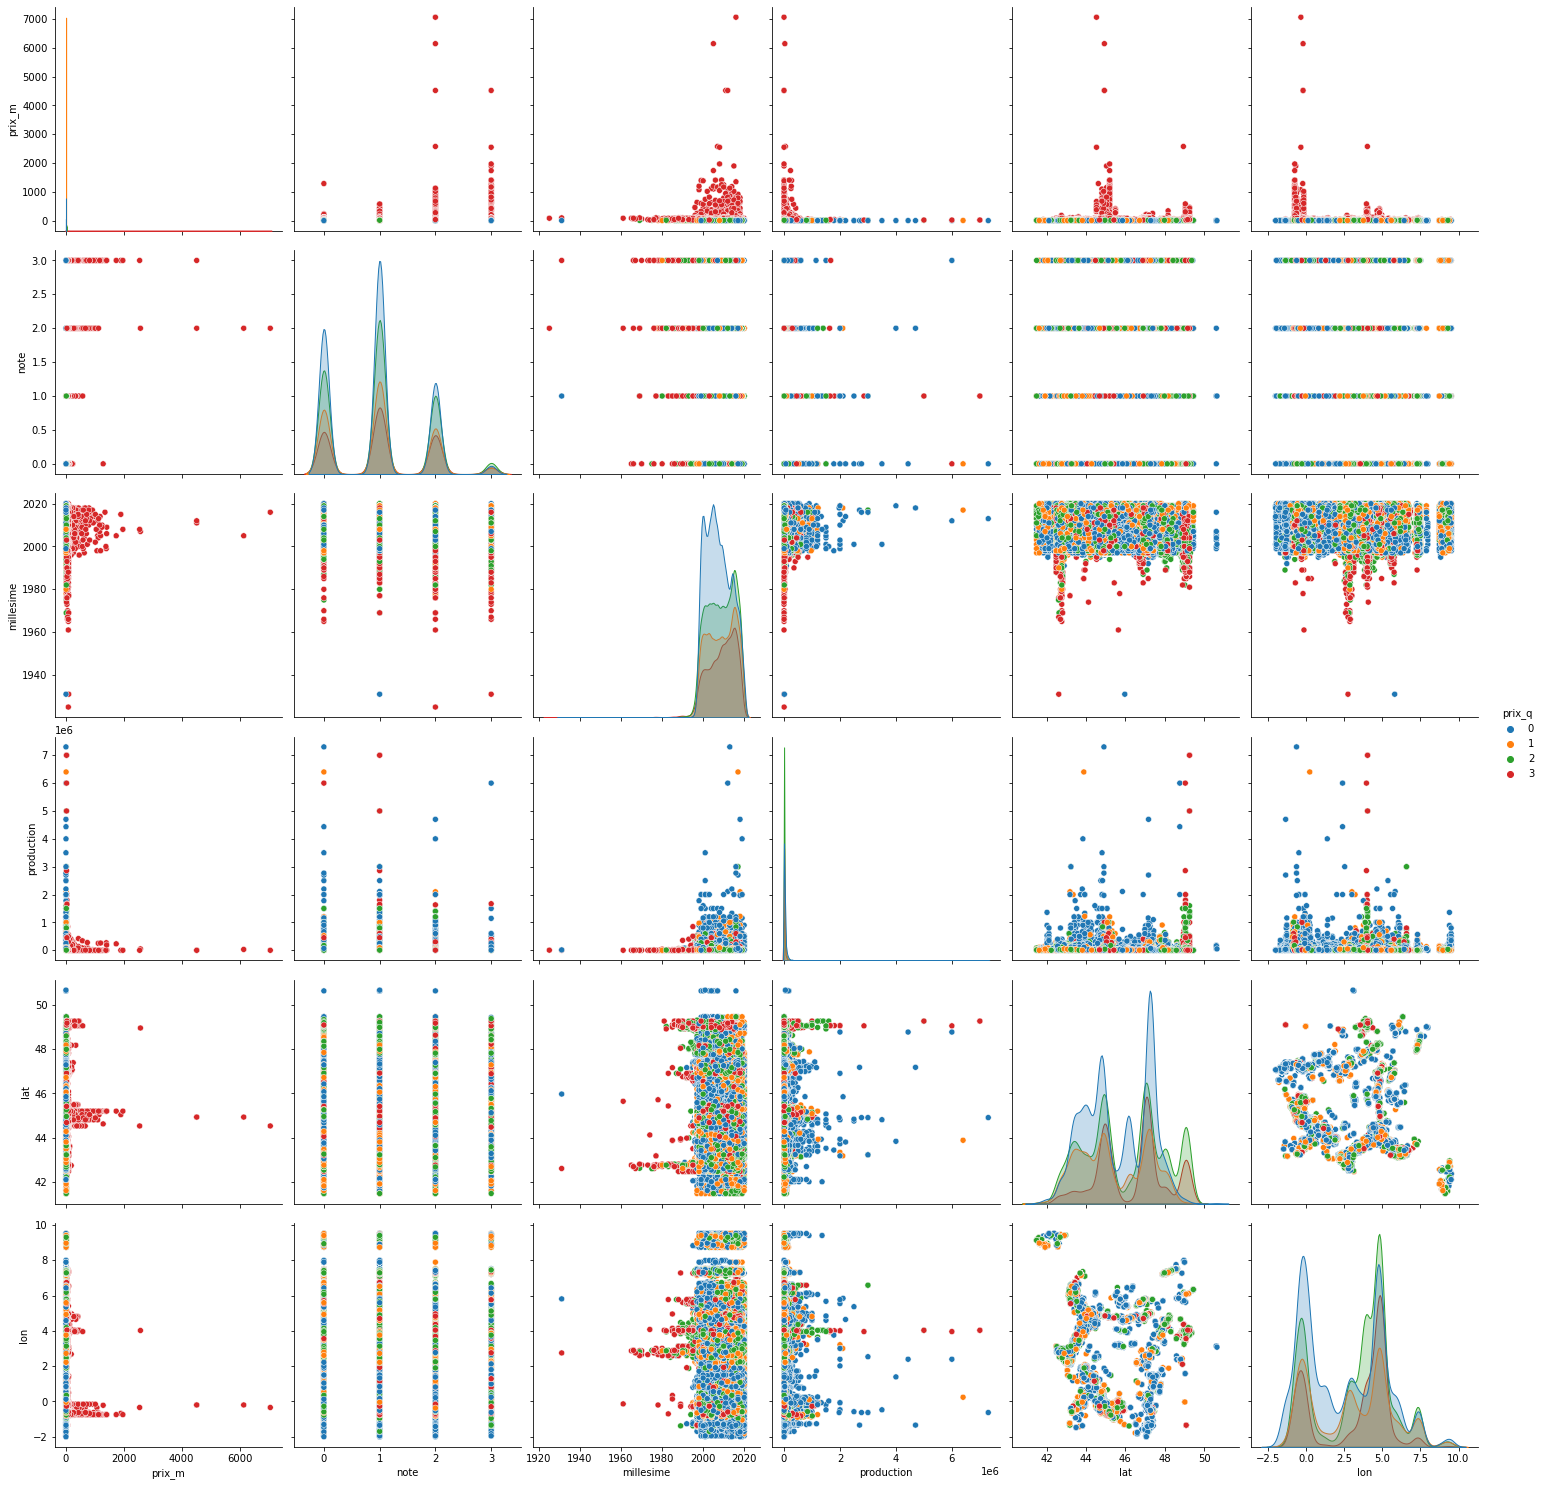

In [9]:
sns.pairplot(df_train, hue='prix_q', vars=['prix_m', 'note', 'millesime', 'production','lat', 'lon'], height=3.5, palette='tab10')
plt.show()

### Location.

A geographical distribution of the prices.

In [21]:
df_train['prix_q'] = df_train['prix_q'].astype(str)
fig = px.scatter_mapbox(df_train, lat='lat', lon='lon', hover_name='vin', hover_data=['appellation', 'cuvee', 'producteur'], zoom=5, 
                        color='prix_q', color_discrete_map ={'0': 'green', '1': 'yellow', '2': 'orange', '3': 'red'})
fig.update_layout(title='Vins de France - Prix (quartile)', mapbox_style='open-street-map')
fig.write_html('Carte de France - quantile.html', auto_open=True)
df_train['prix_q'] = df_train['prix_q'].astype(int)

In [22]:
fig = px.scatter_mapbox(df_train, lat='lat', lon='lon', hover_name='vin', hover_data=['appellation', 'cuvee', 'producteur'], zoom=5, 
                        color=np.log(df_train['prix_m']), color_continuous_scale=px.colors.sequential.Burg, range_color=(1,9))
fig.update_layout(title='Vins de France - Prix (log)', mapbox_style='open-street-map')
fig.write_html('Carte de France - Prix.html', auto_open=True)

### Note.

Relation between note and price?

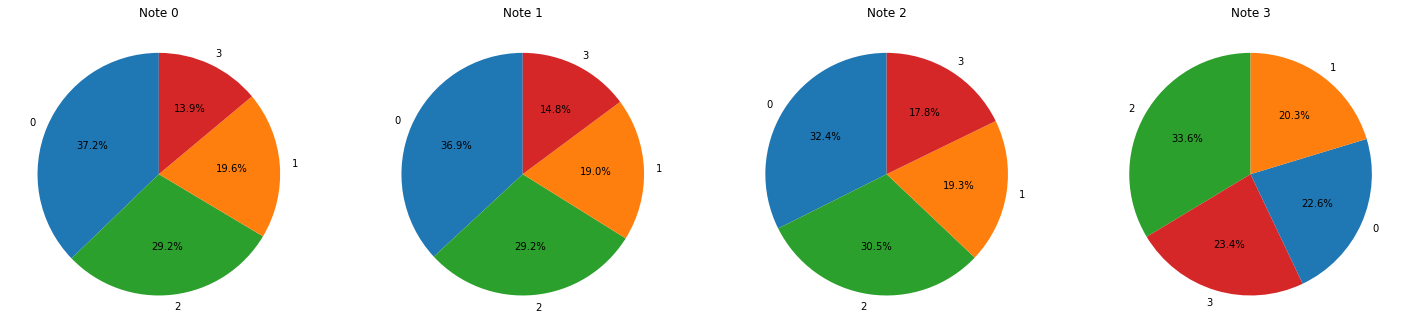

In [24]:
ncol = 4
col = 'note'
l = df_train[df_train[col].notna()][col].unique()
sh = (int(np.ceil(len(l) / ncol)), ncol)
colordict = {'0': plt.cm.tab10(0), '1': plt.cm.tab10(1), '2': plt.cm.tab10(2), '3': plt.cm.tab10(3)}
fig, axes = plt.subplots(nrows=sh[0], ncols=sh[1], figsize =(25,15))
for i, reg in enumerate(np.sort(l)):
    #i = np.unravel_index(i, sh)
    x = df_train[df_train[col]==reg]['prix_q'].sort_values().value_counts()
    wedges = axes[i].pie(x=x, labels=x.index, autopct='%1.1f%%', startangle=90, shadow=False)
    axes[i].set_title('Note {}'.format(reg))  
    for pie_wedge in wedges[0]:
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
plt.show()

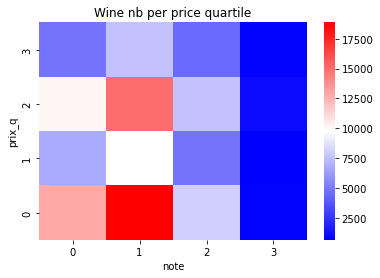

In [12]:
_ = (df_train.groupby(by=['note', 'prix_q'], as_index=False)['vin']
     .count()
     .pivot(index='prix_q', columns='note', values='vin'))
ax = sns.heatmap(_, cmap='bwr')
ax.invert_yaxis()
plt.title('Wine nb per price quartile')
plt.show()

### Millésime

Let's study if Millésime is linked to the price, on the graph below we can suppose so, mainly because of the low number of 3 in rating doesn't allow a proper distribution for this category.

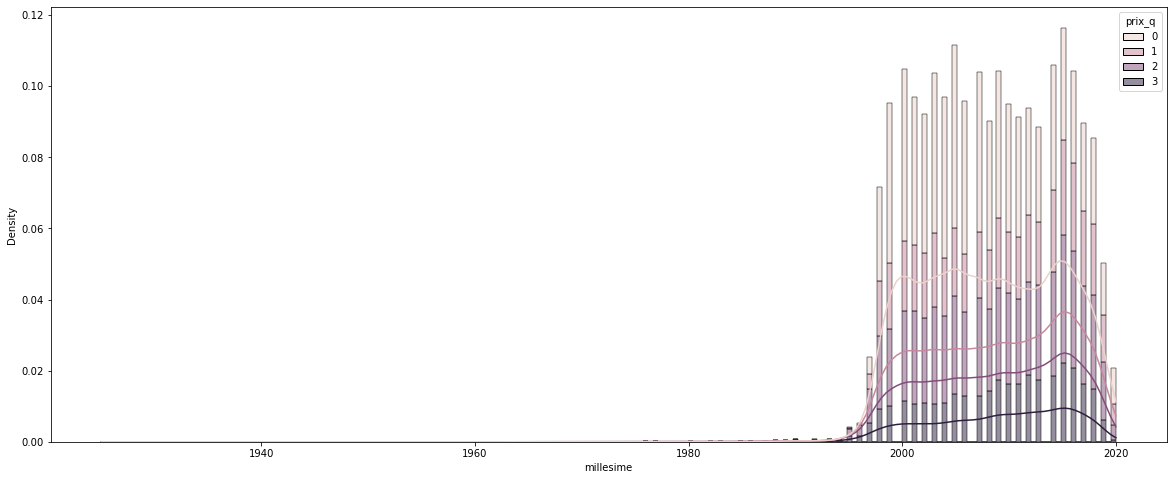

In [13]:
plt.figure(figsize = [20,8])
sns.histplot(data=df_train, x='millesime', hue='prix_q', multiple='stack', stat='density', common_norm=True, kde=True)
plt.show()

#### Regions

Are regions represented uniformaly between the different prices ? There are not as we can see below so we suppose that region are linked to rating.

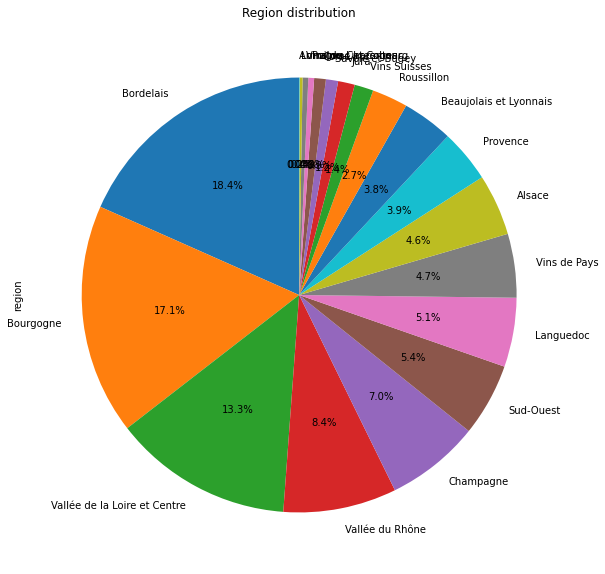

In [14]:
plt.figure(figsize=(10,10))
df_train['region'].value_counts().plot(kind='pie',autopct='%1.1f%%', startangle=90, shadow=False, title='Region distribution')
plt.show()

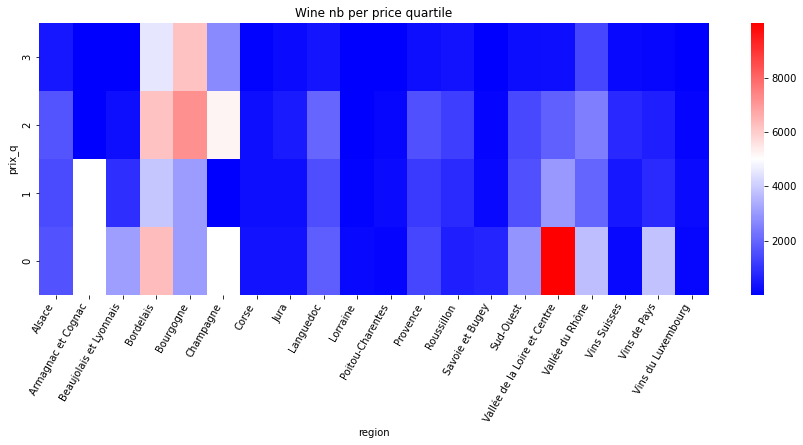

In [15]:
plt.figure(figsize=(15,5))
_ = (df_train.groupby(by=['region', 'prix_q'], as_index=False)['vin']
     .count()
     .pivot(index='prix_q', columns='region', values='vin'))
ax = sns.heatmap(_, cmap='bwr')
ax.invert_yaxis()
plt.xticks(rotation=60, ha='right')
plt.title('Wine nb per price quartile')
plt.show()

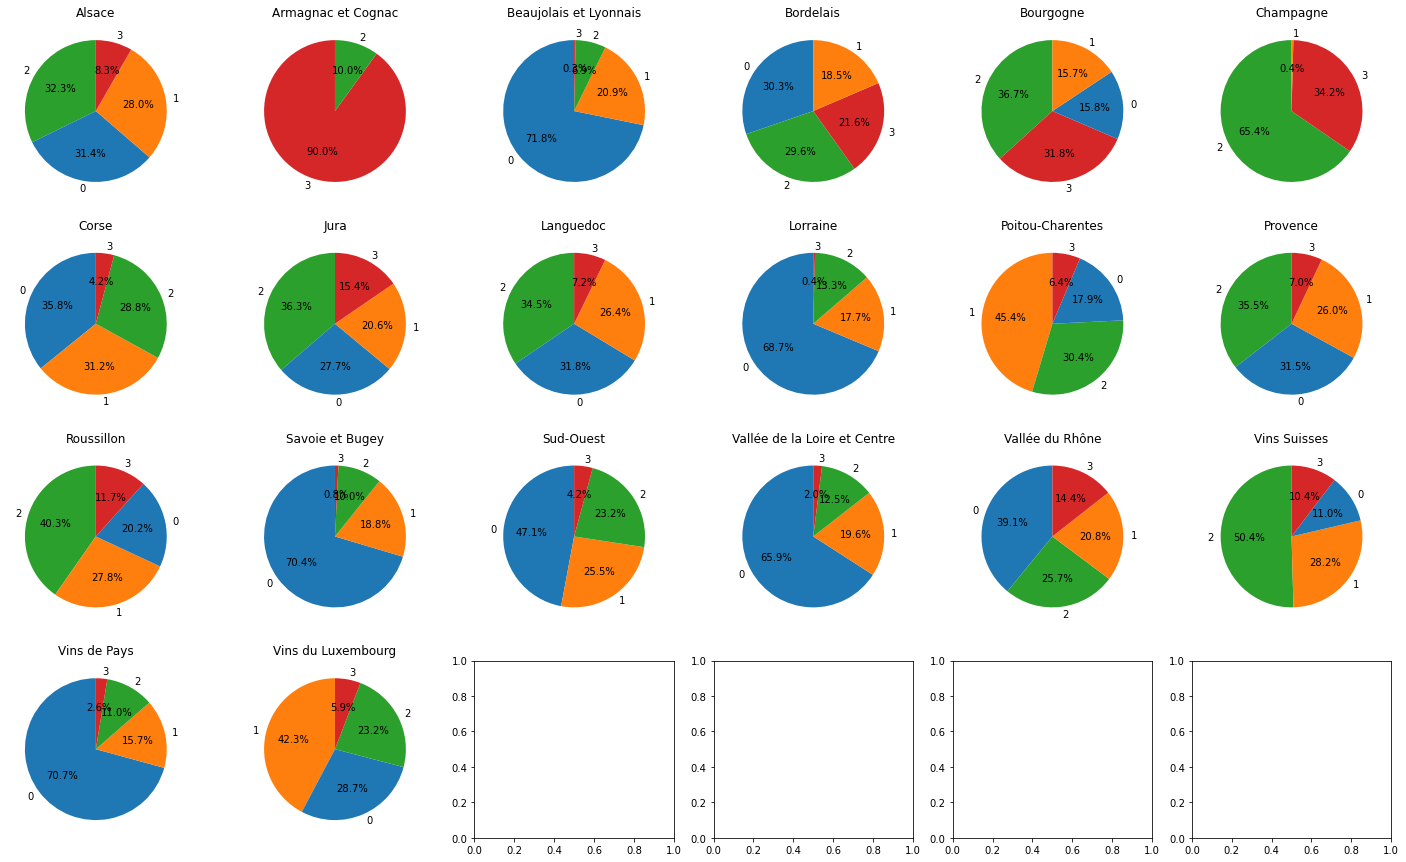

In [16]:
ncol = 6
col = 'region'
l = df_train[df_train[col].notna()][col].unique()
sh = (int(np.ceil(len(l) / ncol)), ncol)
colordict = {'0': plt.cm.tab10(0), '1': plt.cm.tab10(1), '2': plt.cm.tab10(2), '3': plt.cm.tab10(3)}
fig, axes = plt.subplots(nrows=sh[0], ncols=sh[1], figsize =(25,15))
for i, reg in enumerate(np.sort(l)):
    i = np.unravel_index(i, sh)
    x = df_train[df_train[col]==reg]['prix_q'].value_counts()
    wedges = axes[i].pie(x=x, labels=x.index, autopct='%1.1f%%', startangle=90, shadow=False)
    axes[i].set_title(reg)    
    for pie_wedge in wedges[0]:
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
plt.show()

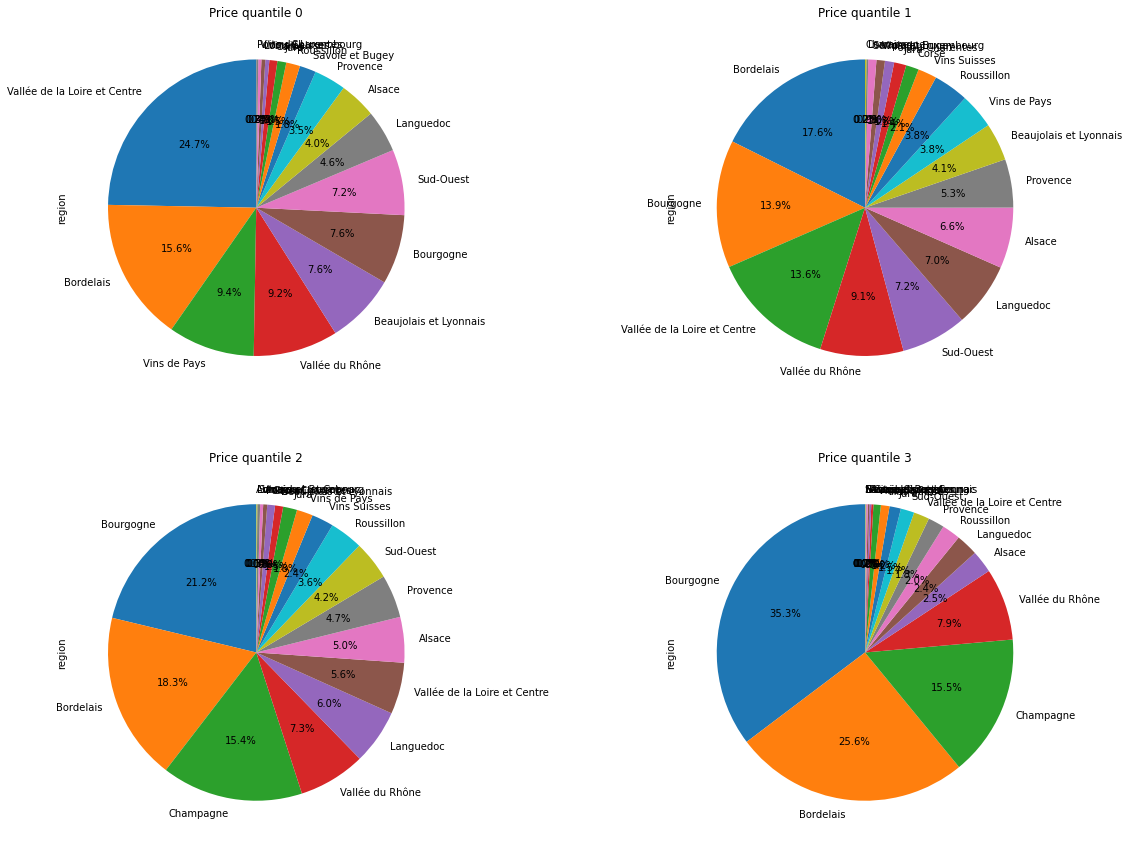

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize =(20,15))
for i in range(4):
    idx = np.unravel_index(i, (2, 2))
    df_train[df_train['prix_q']==i]['region'].value_counts().plot(kind='pie',autopct='%1.1f%%', startangle=90, shadow=False,  ax = axes[idx], title='Price quantile {}'.format(i))
plt.show()

### Type

Let's look at the type of wine we have (rouge (blanc, rosé) tranquille (effervescent).
And this time it seems that the type is not a creterion for the rating.

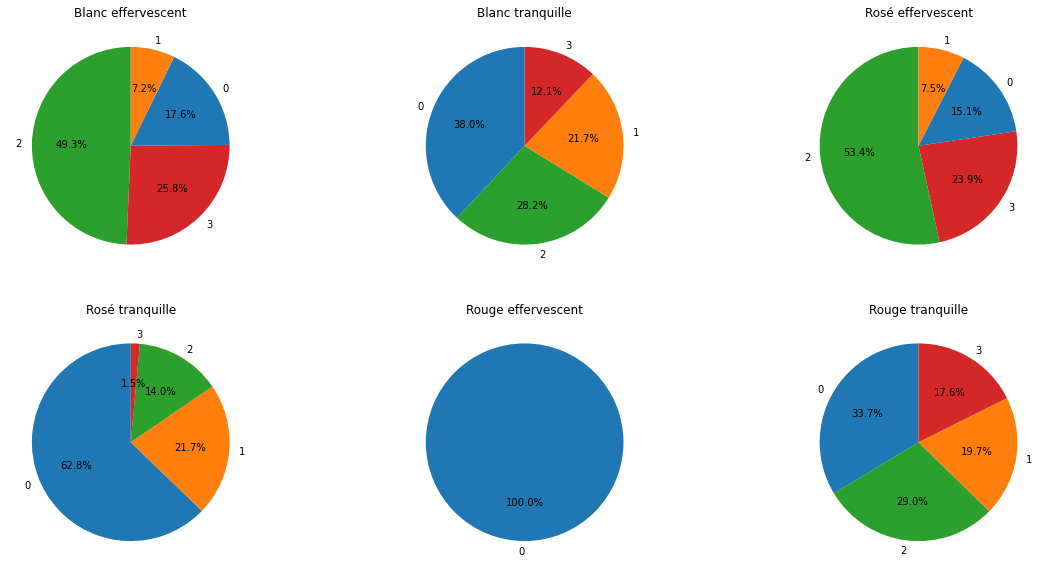

In [18]:
ncol = 3
col = 'type'
l = df_train[df_train[col].notna()][col].unique()
sh = (int(np.ceil(len(l) / ncol)), ncol)
colordict = {'0': plt.cm.tab10(0), '1': plt.cm.tab10(1), '2': plt.cm.tab10(2), '3': plt.cm.tab10(3)}
fig, axes = plt.subplots(nrows=sh[0], ncols=sh[1], figsize =(20,10))
for i, reg in enumerate(np.sort(l)):
    i = np.unravel_index(i, sh)
    x = df_train[df_train[col]==reg]['prix_q'].value_counts()
    wedges = axes[i].pie(x=x, labels=x.index, autopct='%1.1f%%', startangle=90, shadow=False)
    axes[i].set_title(reg)    
    for pie_wedge in wedges[0]:
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
plt.show()

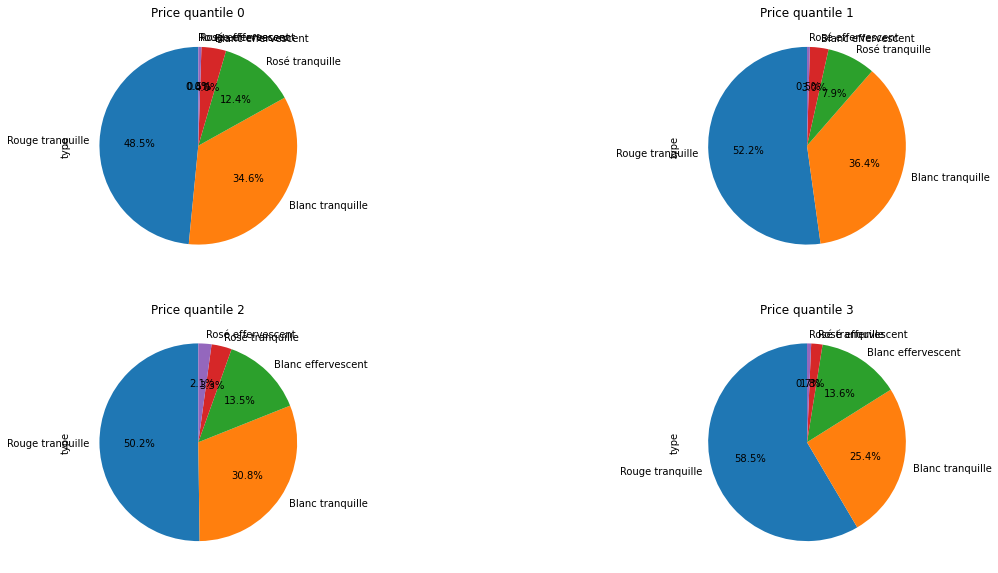

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize =(20,10))
for i in range(4):
    idx = np.unravel_index(i, (2, 2))
    df_train[df_train['prix_q']==i]['type'].value_counts().plot(kind='pie',autopct='%1.1f%%', startangle=90, shadow=False,  ax = axes[idx], title='Price quantile {}'.format(i))
plt.show()

### Consommation

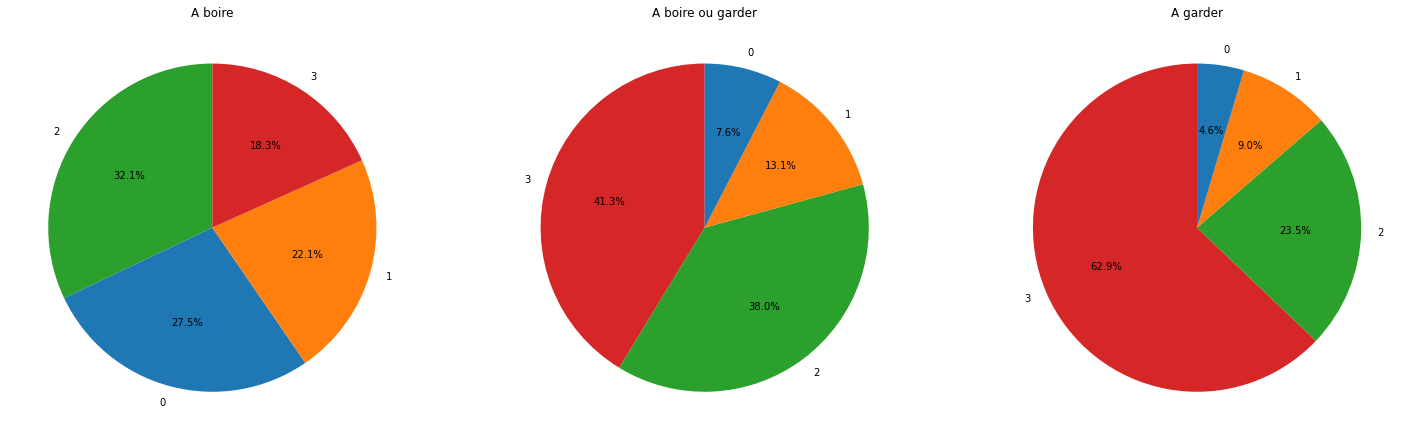

In [20]:
ncol = 3
col = 'consommation'
l = df_train[df_train[col].notna()][col].unique()
sh = (int(np.ceil(len(l) / ncol)), ncol)
colordict = {'0': plt.cm.tab10(0), '1': plt.cm.tab10(1), '2': plt.cm.tab10(2), '3': plt.cm.tab10(3)}
fig, axes = plt.subplots(nrows=sh[0], ncols=sh[1], figsize =(25,15))
for i, reg in enumerate(np.sort(l)):
    #i = np.unravel_index(i, sh)
    x = df_train[df_train[col]==reg]['prix_q'].value_counts()
    wedges = axes[i].pie(x=x, labels=x.index, autopct='%1.1f%%', startangle=90, shadow=False)
    axes[i].set_title(reg)    
    for pie_wedge in wedges[0]:
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
plt.show()

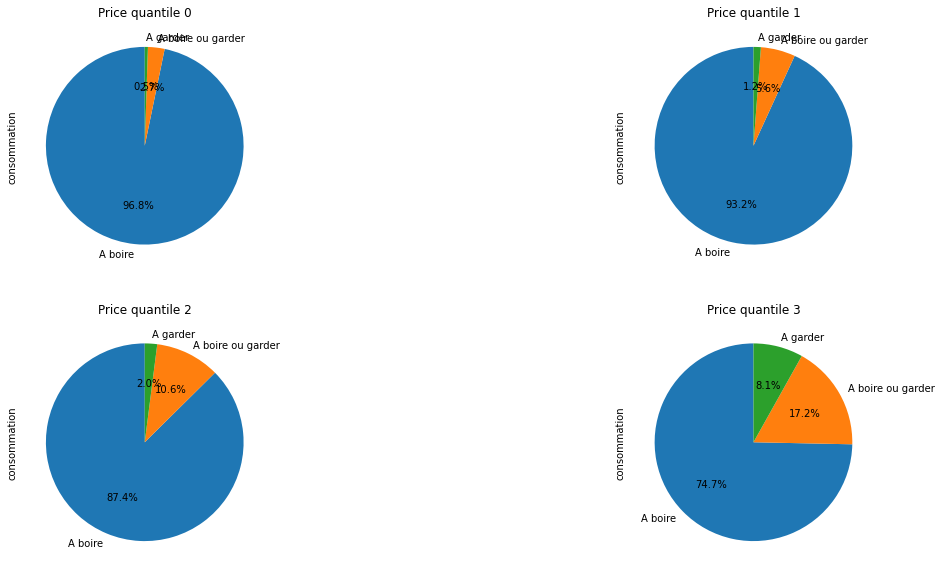

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize =(20,10))
for i in range(4):
    idx = np.unravel_index(i, (2, 2))
    df_train[df_train['prix_q']==i]['consommation'].value_counts().plot(kind='pie',autopct='%1.1f%%', startangle=90, shadow=False,  ax = axes[idx], title='Price quantile {}'.format(i))
plt.show()

# Classement

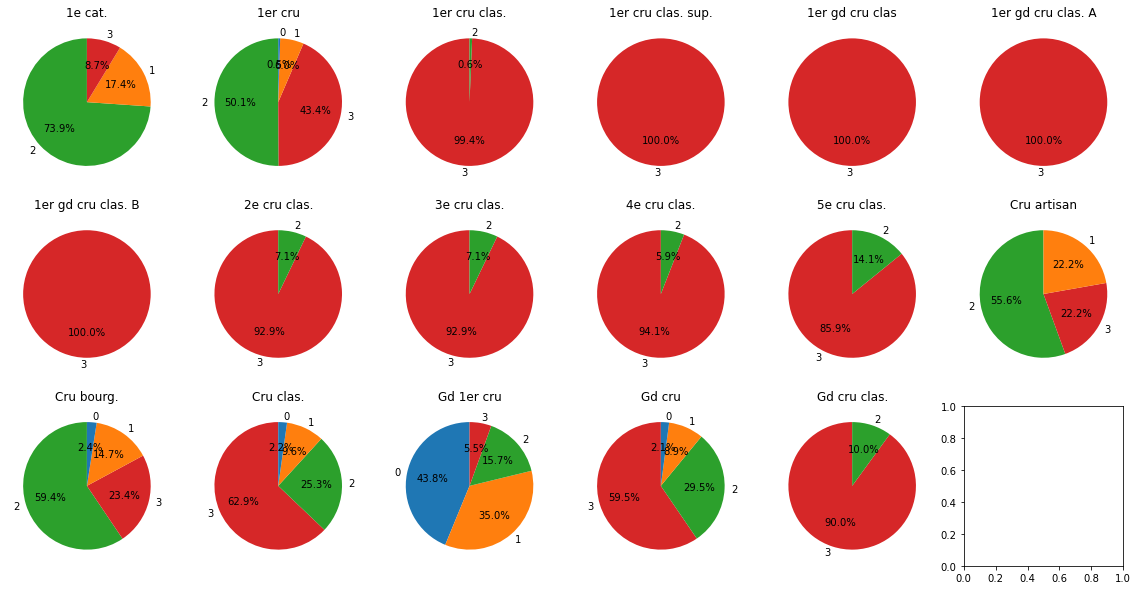

In [22]:
col = 6
l = df_train[df_train['classement'].notna()]['classement'].unique()
sh = (int(np.ceil(len(l) / col)), col)
colordict = {'0': plt.cm.tab10(0), '1': plt.cm.tab10(1), '2': plt.cm.tab10(2), '3': plt.cm.tab10(3)}
fig, axes = plt.subplots(nrows=sh[0], ncols=sh[1], figsize =(20,10))
for i, reg in enumerate(np.sort(l)):
    i = np.unravel_index(i, sh)
    x = df_train[df_train['classement']==reg]['prix_q'].value_counts()
    wedges = axes[i].pie(x=x, labels=x.index, autopct='%1.1f%%', startangle=90, shadow=False)
    axes[i].set_title(reg)    
    for pie_wedge in wedges[0]:
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
plt.show()

The classement is relevant to study rating 

# Elevage

This one is difficult, it seems that if you are a "en cuve et en fût" you are less likely to get a 3 as a rating. So rating depends on Elevage.

### Conclusion

We didn't look at the variables : cuvee, appellation, production, producteur du to a lack of data as this variables have a great number of possiblities.

For the rest of the variable, we figured out that the type of wine is not relevant to study the rating. 

# Basic model.

## Train set preparation.

In [23]:
df_train = pd.read_csv('data/train.csv', sep=';', encoding='utf-8')

# Elimination des vins dont on ne dispose pas du millesime ou du prix
df_train = df_train[~df_train['millesime'].isna()].reset_index(drop=True)

Y_train = df_train[['prix_m']].copy()

# Elimination de certaines colonnes
X_train = df_train.drop(columns=['guide', 'prix',
                                 'prix_min', 'prix_max', 'prix_m',
                                 'garde', 'cuvee',
                                 'prod_id',
                                 'adresse', 'CP', 'commune', 'pays',
                                 'INSEE_COM', 'INSEE_DEP', 'INSEE_REG'])

## Test set preparation.

In [24]:
df_test = pd.read_csv('data/test.csv', sep=';', encoding='utf-8')

# Elimination des vins dont on ne dispose pas du millesime ou du prix
df_test = df_test[~df_test['millesime'].isna()].reset_index(drop=True)

Y_test = df_test[['prix_m']].copy()

# Elimination de certaines colonnes
X_test = df_test.drop(columns=['guide', 'prix',
                               'prix_min', 'prix_max', 'prix_m',
                               'garde', 'cuvee',
                               'prod_id',
                               'adresse', 'CP', 'commune', 'pays',
                               'INSEE_COM', 'INSEE_DEP', 'INSEE_REG'])

## Model definition.

In [25]:
ohe_cols = ['classement', 'region', 'commentaire', 'type', 'consommation', 'elevage']
tgt_cols = ['vin', 'producteur', 'appellation']

In [26]:
ohe_pipeline = Pipeline([
    #("imputer", SimpleImputer(strategy='constant', fill_value='missing')),
    ("one-hot-encoder", OneHotEncoder(handle_unknown='ignore'))
])

tgt_pipeline = Pipeline([
    ("target-encoder", ce.TargetEncoder())
])

preprocessing = ColumnTransformer([
    ("ohe_preproc", ohe_pipeline, ohe_cols),
    ("tgt_preproc", tgt_pipeline, tgt_cols)
])

model = Pipeline([
    ("Preprocessing", preprocessing),
    ("regressor", LinearRegression())
])
model.fit(X_train, Y_train)

C:\Users\ROG-Hub\anaconda3\envs\Travail\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.



Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('ohe_preproc',
                                                  Pipeline(steps=[('one-hot-encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['classement', 'region',
                                                   'commentaire', 'type',
                                                   'consommation', 'elevage']),
                                                 ('tgt_preproc',
                                                  Pipeline(steps=[('target-encoder',
                                                                   TargetEncoder())]),
                                                  ['vin', 'producteur',
                                                   'appellation'])])),
                ('regressor', LinearRegression())])

In [27]:
from sklearn.metrics import mean_absolute_percentage_error

In [28]:
Y_train_hat = model.predict(X_train)
mean_absolute_percentage_error(Y_train, Y_train_hat)

0.34528706851813235

In [29]:
Y_test_hat = model.predict(X_test)
mean_absolute_percentage_error(Y_test, Y_test_hat)

0.39152763586861467